In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq

from ipywidgets import interact, FloatSlider, IntSlider

In [10]:
class model:
    def __init__(self, 
                psi     = 0.2,      # management fee
                eta     = 0.36,     # pledgeability
                chi     = 1.5,      # productivity
                alpha   = 0.48,
                xi      = 0.3,      # cost of R_P
                beta    = 0.95, 
                eps     = 0.2,
                N       = 1,
                A       = 1,
                C       = 0.03):
        self.psi, self.eta, self.chi, self.alpha, self.xi = psi, eta, chi, alpha, xi
        self.beta, self.eps, self.N, self.C, self.A = beta, eps, N, C, A

        # convenient parameters
        P_factor = chi**((1-alpha)/alpha)
        multiplier = (1 + xi)/(1 + xi - eta*P_factor)

        self.assumption1 = P_factor-(1+psi)

        self.P_factor, self.multiplier = P_factor, multiplier
    
    def compute_RS(self, kS, kP):
        "Compute R_S"
        eps, P_factor, A, N, alpha, psi = self.eps, self.P_factor, self.A, self.N, self.alpha, self.psi

        w_sum = (1-eps)*kS + eps*P_factor*kP

        return alpha*(1-psi)*(w_sum/(A*N))**(alpha-1)
    
    def output(self, kS, kP):
        "Calculate both types of firm's output"
        alpha, psi, P_factor = self.alpha, self.psi, self.P_factor

        RS = self.compute_RS(kS, kP)
        RS_tild = RS/(alpha*(1-psi))

        yS = RS_tild*kS
        yP = P_factor*RS_tild*kP

        return yS, yP

    def labor(self, kS, kP):
        "Compute the labor allocation"
        N, eps, P_factor = self.N, self.eps, self.P_factor

        kappa = kS/kP
        nS = N*kappa/((1-eps)*kappa + eps*P_factor)
        nP = (N - (1-eps)*nS)/eps
        return nS, nP
    
    def loan(self, kS, kP):
        "C - loan to P per firm"
        C, eps, multiplier, beta, psi = self.C, self.eps, self.multiplier, self.beta, self.psi

        yS, yP = self.output(kS, kP)

        loanP = eps * (multiplier-1)/(1+1/beta) * psi*yP
        loanS = C - loanP
        return loanS, loanP
    
    def update(self, kS, kP):
        "Transition law of the system"
        beta, multiplier, psi, eps = self.beta, self.multiplier, self.psi, self.eps

        yS, yP = self.output(kS, kP)
        loanS, loanP = self.loan(kS, kP)

        kP_next = multiplier/(1+1/beta) * psi*yP
        kS_next = 1/(1+1/beta) * psi*yS + loanS/(1-eps)
        return kS_next, kP_next

    def steady_state(self):
        C, eps, psi, beta, alpha, A, N = self.C, self.eps, self.psi, self.beta, self.alpha, self.A, self.N
        multiplier, P_factor = self.multiplier, self.P_factor

        # S firm steady state
        kS_Sfirm_ss = lambda k: C/(1-eps) + psi/(1+1/beta) * k**alpha * (A*N/(1-eps))**(1-alpha) - k
        kS_Sfirm_ss = brentq(kS_Sfirm_ss, 0, 50)

        RS_Sfirm_ss = alpha*(1-psi)*((1-eps)*kS_Sfirm_ss/(A*N))**(alpha-1)

        # Coexist steady state
        RS_Coex_ss = alpha*(1-psi)/psi * (1+1/beta)/multiplier * 1/P_factor

        self.RS_Sfirm_ss, self.RS_Coex_ss = RS_Sfirm_ss, RS_Coex_ss
        return RS_Sfirm_ss, RS_Coex_ss
    
    def coex_capital(self):
        multiplier, psi, beta, alpha, chi, A, N, eps = self.multiplier, self.psi, self.beta, self.alpha, self.chi, self.A, self.N, self.eps
        P_factor, C = self.P_factor, self.C

        PartA = (psi*multiplier/(1+1/beta))**(1/(1-alpha))
        PartB = multiplier/(multiplier-1/P_factor)
        PartC = (multiplier-1)/(multiplier-1/P_factor)
        PartD = chi**(-1/alpha)

        kP = 1/eps * (1/chi - PartD*PartC)**(-1) * (A*N*PartA - PartD*PartB*C)
        kS = PartB*(1/(1-eps))*C - (eps/(1-eps)) * (PartC)*kP

        return kS, kP

    
    def simulate(self, kS0, kP0, T, C_shock_T=None, C_shock=None):
        "Simulate a path of T"
        orig_C = self.C

        kS_path = np.zeros(T+1)
        kP_path = np.zeros(T+1)

        kS_path[0] = kS0
        kP_path[0] = kP0
        kS_curr, kP_curr = kS0, kP0

        for t in range(1, T+1):

            if C_shock_T!=None:
                if (t==C_shock_T[0]):
                    self.C = C_shock
                if (t==C_shock_T[1]):
                    self.C = orig_C

            kS_curr, kP_curr = self.update(kS_curr, kP_curr)
            kS_path[t] = kS_curr
            kP_path[t] = kP_curr
        
        self.C = orig_C

        return kS_path, kP_path

    def unpack(self, kS_path, kP_path):
        "Unpack simulated results"
        eps, C = self.eps, self.C
        beta, psi, multiplier = self.beta, self.psi, self.multiplier
        T = len(kS_path)

        # get steady state
        RS_Sfirm_ss, RS_Coex_ss = self.steady_state()

        RS_path  = np.zeros(T)
        yS_path  = np.zeros(T)
        yP_path  = np.zeros(T)
        nS_path  = np.zeros(T)
        nP_path  = np.zeros(T)
        loanS_path  = np.zeros(T)
        loanP_path  = np.zeros(T)
        kP_growth_path  = np.zeros(T)
        kS_growth_path  = np.zeros(T)

        for t in range(T):
            kS, kP = kS_path[t], kP_path[t]
            RS_path[t] = self.compute_RS(kS, kP)
            yS_path[t], yP_path[t] = self.output(kS, kP)
            nS_path[t], nP_path[t] = self.labor(kS, kP)
            loanS_path[t], loanP_path[t] = self.loan(kS, kP)        # total loan
        
        kP_growth_path[1:] = kP_path[1:]/kP_path[:-1]
        kS_growth_path[1:] = kS_path[1:]/kS_path[:-1]
        
        mS_path, mP_path = psi*yS_path, psi*yP_path
        iS_path = 1/(1+1/beta) * mS_path
        lP_path = (multiplier - 1)/(1+1/beta) * mP_path
        lS_path = (C - eps*lP_path)/(1-eps)
        
        leverage_S_path = lS_path/iS_path

        return (RS_path, yS_path, yP_path, nS_path, nP_path, loanS_path, loanP_path, 
                kS_path, kP_path, kS_growth_path, kP_growth_path, leverage_S_path)
    
    def plot(self, kS_path, kP_path):
        "Plot unpacked result"
        C, N, P_factor, eps = self.C, self.N, self.P_factor, self.eps

        # truncate step
        # kS_path, kP_path = kS_path[3:], kP_path[3:]

        T = int(len(kS_path))
        T_arr = range(T)
        (RS_path, yS_path, yP_path, nS_path, nP_path, loanS_path, loanP_path, 
            kS_path, kP_path, kS_growth_path, kP_growth_path, leverage_S_path) = self.unpack(kS_path, kP_path)
        
        RP_path = P_factor*RS_path

        # normalize
        yS_path = yS_path * (1-eps)
        yP_path = yP_path * eps
        nS_path = nS_path * (1-eps)
        nP_path = nP_path * eps
        kS_path = kS_path * (1-eps)
        kP_path = kP_path * eps

        nS_share = nS_path/N
        nP_share = nP_path/N
        kS_share = kS_path/(kS_path+kP_path)
        kP_share = kP_path/(kS_path+kP_path)
        Cr_S_share = loanS_path/C
        Cr_P_share = loanP_path/C

        fig, ax = plt.subplots(2,3, figsize=[20,10], dpi=200)
        ax[0, 0].plot(T_arr, kS_path, label='kS')
        ax[0, 0].plot(T_arr, kP_path, label='kP')
        ax[0, 0].plot(T_arr, C*np.ones(T), label='C')

        ax[0, 1].plot(T_arr, RS_path, label='RS')
        ax[0, 1].plot(T_arr, RP_path, label='RP')
        # ax[0, 1].plot(T_arr, kS_growth_path, label='kS growth')
        # ax[0, 1].plot(T_arr, kP_growth_path, label='kP growth')
        ax[0, 1].hlines(self.RS_Sfirm_ss, 0, T, 'red', label='RS_Sfirm_ss')
        ax[0, 1].hlines(self.RS_Coex_ss, 0, T, 'blue', label='RS_Coex_ss')

        ax[0, 2].plot(T_arr, loanS_path, label='loanS')
        ax[0, 2].plot(T_arr, loanP_path, label='loanP')
        ax[0, 2].plot(T_arr, C*np.ones(T), label='C')

        ax[1, 0].plot(T_arr, nS_path, label='nS')
        ax[1, 0].plot(T_arr, nP_path, label='nP')
        ax[1, 0].plot(T_arr, N*np.ones(T), label='N')

        ax[1, 1].plot(T_arr, yS_path, label='yS')
        ax[1, 1].plot(T_arr, yP_path, label='yP')
        ax[1, 1].plot(T_arr, C*np.ones(T), label='C')

        ax[1, 2].plot(T_arr, nS_share, label='nS share', color='tab:blue')
        ax[1, 2].plot(T_arr, nP_share, label='nP share', ls='-.', color='tab:blue')
        ax[1, 2].plot(T_arr, kS_share, label='kS share', color='tab:orange')
        ax[1, 2].plot(T_arr, kP_share, label='kP share', ls='-.', color='tab:orange')
        ax[1, 2].plot(T_arr, Cr_S_share, label='credit S share', color='tab:green')
        ax[1, 2].plot(T_arr, Cr_P_share, label='credit P share', ls='-.', color='tab:green')

        for i in [0,1]:
            for j in [0,1,2]:
                ax[i,j].legend()

        plt.show()

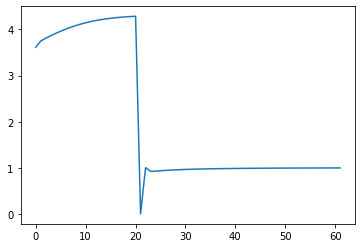

In [28]:
# A temporary credit shock

my_class = model(
    psi     = 0.4,      # management fee
    eta     = 0.36,     # pledgeability
    chi     = 1.45,      # productivity
    alpha   = 0.35,
    xi      = 0.35,      # cost of R_P
    beta    = 0.95, 
    eps     = 0.5,
    N       = 2,
    A       = 1,
    C       = 0.8
)


kS0, kP0 = 2, 0.4
T1 = 20
T2 = 40
T_path = range(T1+T2+2)
kS_path1, kP_path1 = my_class.simulate(kS0, kP0, T1)

# shock
my_class.C = 1.0
kS_path2, kP_path2 = my_class.simulate(kS_path1[-1], kP_path1[-1], T2)


# (RS_path, yS_path, yP_path, nS_path, nP_path, loanS_path, loanP_path, 
#     kS_path, kP_path, kS_growth_path, kP_growth_path, leverage_S_path) 

result1 = my_class.unpack(kS_path1, kP_path1)
result2 = my_class.unpack(kS_path2, kP_path2)
leverage_path = np.concatenate([result1[-1], result2[-2]])

plt.plot(T_path, leverage_path)


Assumption 1 0.5938084521283282
RS_Sfirm_ss 0.3064874584766494
RS_Coex_ss 0.2531206002457937


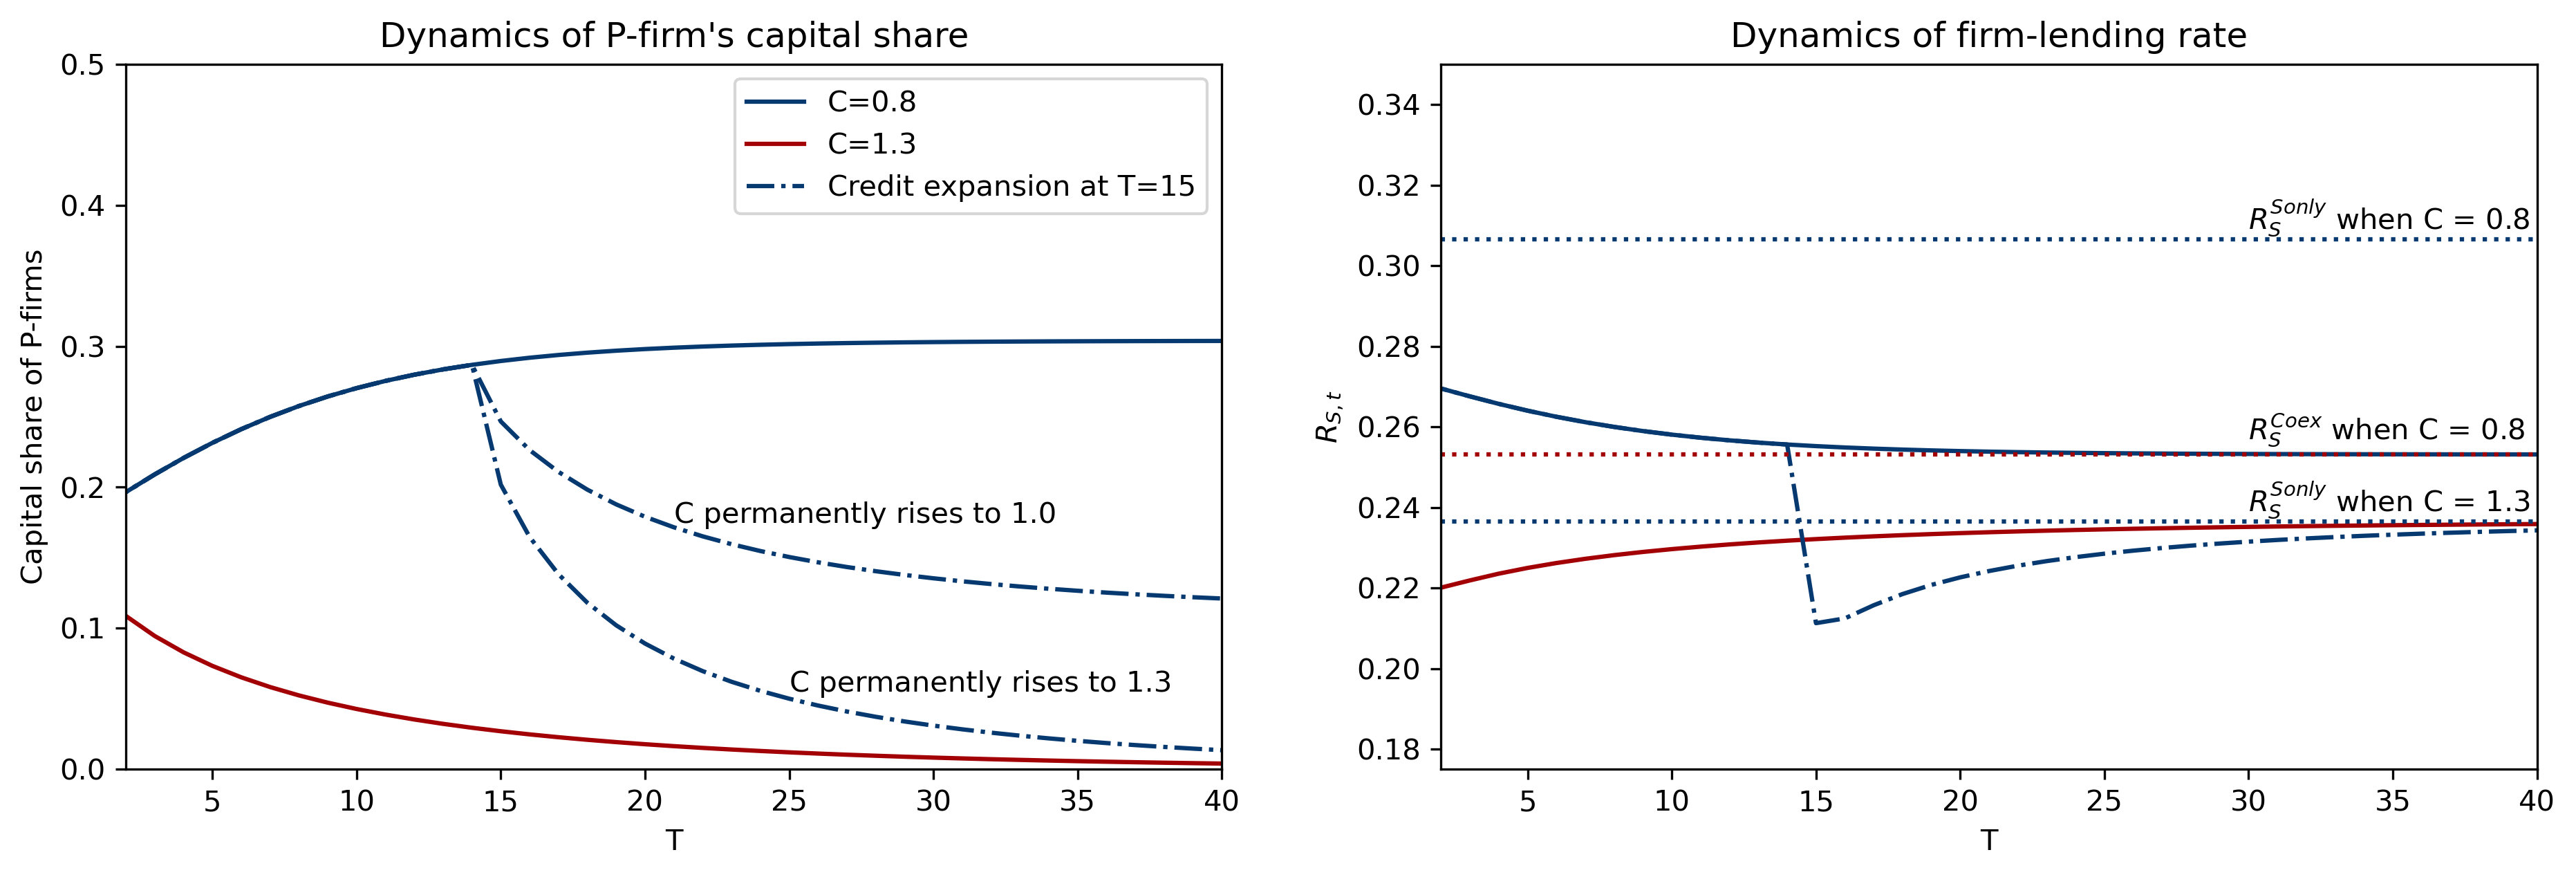

In [12]:
my_class = model(
    psi     = 0.4,      # management fee
    eta     = 0.36,     # pledgeability
    chi     = 1.45,      # productivity
    alpha   = 0.35,
    xi      = 0.35,      # cost of R_P
    beta    = 0.95, 
    eps     = 0.5,
    N       = 2,
    A       = 1,
    C       = 0.8
)

kS0, kP0 = 2, 0.4
T = 40
T_path = range(T+1)

RS_Sfirm_ss, RS_Coex_ss = my_class.steady_state()
print('Assumption 1', my_class.assumption1)
print('RS_Sfirm_ss', RS_Sfirm_ss)
print('RS_Coex_ss', RS_Coex_ss)

kS_coex, kP_coex = my_class.coex_capital()

kS_path, kP_path = my_class.simulate(kS0, kP0, T)
kP_share = my_class.eps*kP_path/((1-my_class.eps)*kS_path + my_class.eps*kP_path)

(RS_path, yS_path, yP_path, nS_path, nP_path, loanS_path, loanP_path, 
    kS_path, kP_path, kS_growth_path, kP_growth_path, leverage_S_path) = my_class.unpack(kS_path, kP_path)


RS_Sfirm_ss, RS_Coex_ss = my_class.steady_state()

# case 2
my_class.C = 1.3
kS_path2, kP_path2 = my_class.simulate(kS0, kP0, T)
kP_share2 = my_class.eps*kP_path2/((1-my_class.eps)*kS_path2 + my_class.eps*kP_path2)

(RS_path2, yS_path2, yP_path2, nS_path2, nP_path2, loanS_path2, loanP_path2, 
    kS_path2, kP_path2, kS_growth_path2, kP_growth_path2, leverage_S_path2) = my_class.unpack(kS_path2, kP_path2)


RS_Sfirm_ss2, RS_Coex_ss2 = my_class.steady_state()

# case 3
my_class.C = 0.8
kS_path3, kP_path3 = my_class.simulate(kS0, kP0, T, C_shock_T=[15, 61], C_shock=1.3)
kP_share3 = my_class.eps*kP_path3/((1-my_class.eps)*kS_path3 + my_class.eps*kP_path3)

(RS_path3, yS_path3, yP_path3, nS_path3, nP_path3, loanS_path3, loanP_path3, 
    kS_path3, kP_path3, kS_growth_path3, kP_growth_path3, leverage_S_path3) = my_class.unpack(kS_path3, kP_path3)


# case 4
my_class.C = 0.8
kS_path4, kP_path4 = my_class.simulate(kS0, kP0, T, C_shock_T=[15, 61], C_shock=1.0)
kP_share4 = my_class.eps*kP_path4/((1-my_class.eps)*kS_path4 + my_class.eps*kP_path4)

(RS_path4, yS_path4, yP_path4, nS_path4, nP_path4, loanS_path4, loanP_path4, 
    kS_path4, kP_path4, kS_growth_path4, kP_growth_path4, leverage_S_path4) = my_class.unpack(kS_path4, kP_path4)



fig, ax = plt.subplots(1,2, figsize=[15,4.5], dpi=300)
ax[0].plot(T_path, kP_share, '-', color='#063970', label='C=0.8')
ax[0].plot(T_path, kP_share2, '-', color='#A30006', label='C=1.3')
ax[0].plot(T_path, kP_share3, '-.', color='#063970', label='Credit expansion at T=15')
ax[0].plot(T_path, kP_share4, '-.', color='#063970')

ax[1].plot(T_path, RS_path, '-', color='#063970', label='C=0.8')
ax[1].plot(T_path, RS_path2, '-', color='#A30006', label='C=1.3')
ax[1].plot(T_path, RS_path3, '-.', color='#063970', label='C increases to 1.3 at T=15')
ax[1].hlines(RS_Sfirm_ss, 0, T, ls=':', color='#063970')
ax[1].hlines(RS_Sfirm_ss2, 0, T, ls=':', color='#063970')
ax[1].hlines(RS_Coex_ss, 0, T, ls=':', color='#A30006')
ax[1].set_ylim([0.175,0.35])
ax[1].set_xlim([2,T])

ax[0].set_xlim([2,T])
ax[0].set_ylim([0, 0.5])
ax[0].set_title("Dynamics of P-firm's capital share")
ax[0].set_xlabel('T')
ax[0].set_ylabel("Capital share of P-firms")
ax[0].annotate('C permanently rises to 1.0', xy=[21,0.175])
ax[0].annotate('C permanently rises to 1.3', xy=[25,0.055])
ax[1].set_title("Dynamics of firm-lending rate")
ax[1].set_xlabel('T')
ax[1].set_xlabel('T')
ax[1].set_ylabel("$R_{S,t}$")
ax[1].annotate('$R_S^{Coex}$ when C = 0.8', xy=[30, 0.257])
ax[1].annotate('$R_S^{Sonly}$ when C = 1.3', xy=[30, 0.239])
ax[1].annotate('$R_S^{Sonly}$ when C = 0.8', xy=[30, 0.309])
# ax[1].annotate('$R_S^{Sonly}$ when C = 0.8', xy=[30, 0.257])

ax[0].legend()
# ax[0].legend()

plt.show()

In [13]:
my_class.coex_capital()

(1.6044041692452233, 0.7005085258779983)

In [14]:
# paramterize RS_Coex_ss

def find_RS_above1(psi, eta, chi, alpha, xi, beta, eps, N, A, C):
    my_class = model(psi, eta, chi, alpha, xi, beta, eps, N, A, C)
    RS_Sfirm_ss, RS_Coex_ss = my_class.steady_state()
    print('Assumption 1', my_class.assumption1)
    print('RS_Sfirm_ss', RS_Sfirm_ss)
    print('RS_Coex_ss', RS_Coex_ss)

def plot_param(psi, eta, chi, alpha, xi, beta, eps, N, A, C, kS0, kP0):
    T = 30
    my_class = model(psi, eta, chi, alpha, xi, beta, eps, N, A, C)
    RS_Sfirm_ss, RS_Coex_ss = my_class.steady_state()

    kS_path, kP_path = my_class.simulate(kS0, kP0, T)
    print('Assumption 1', my_class.assumption1)
    print('RS_Sfirm_ss', RS_Sfirm_ss)
    print('RS_Coex_ss', RS_Coex_ss)

    my_class.plot(kS_path, kP_path)

interact(
    plot_param, 
    psi = FloatSlider(value=0.26, min=0.01, max=0.99, step=0.001), 
    eta = FloatSlider(value=0.36, min=0.01, max=0.99, step=0.001), 
    chi = FloatSlider(value=1.68, min=0.01, max=2, step=0.001), 
    alpha = FloatSlider(value=0.43, min=0.01, max=0.99, step=0.001), 
    xi = FloatSlider(value=0.3, min=0.01, max=0.99, step=0.001), 
    beta = FloatSlider(value=0.95, min=0.01, max=0.99, step=0.001), 
    eps = FloatSlider(value=0.62, min=0.01, max=0.99, step=0.001), 
    N = FloatSlider(value=2, min=0.01, max=5, step=0.001), 
    A = FloatSlider(value=2, min=0.5, max=5, step=0.001),
    C = FloatSlider(value=0.73, min=0.01, max=5, step=0.001),
    kS0 = FloatSlider(value=0.6, min=0.01, max=5, step=0.001),
    kP0 = FloatSlider(value=0.2, min=0.01, max=5, step=0.001),
)

interactive(children=(FloatSlider(value=0.26, description='psi', max=0.99, min=0.01, step=0.001), FloatSlider(…

<function __main__.plot_param(psi, eta, chi, alpha, xi, beta, eps, N, A, C, kS0, kP0)>